# Load the imports

In [1124]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tabulate import tabulate

# Load the dataset

In [1125]:
df = pd.read_csv('maternal_health_risk_data_set.csv')
df.head()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk


# Data preprocessing

In [1126]:
# Check for missing values
missing_values = df.isnull().sum()

missing_values

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

In [1127]:
# Check for class imbalance
class_distribution = df['RiskLevel'].value_counts(normalize=True) * 100
class_distribution

low risk     40.039448
mid risk     33.136095
high risk    26.824458
Name: RiskLevel, dtype: float64

In [1128]:
# There is a slight imbalance, but it's not severe.

# Encode the target into numerical values
label_encoder = LabelEncoder()
df['RiskLevel'] = label_encoder.fit_transform(df['RiskLevel'])

# Extract the features and target
X = df.drop('RiskLevel', axis=1)
y = df['RiskLevel']

# Normalize the continuous features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, train_size=0.8, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((811, 6), (203, 6), (811,), (203,))

In [1129]:
label_encoder.classes_

array(['high risk', 'low risk', 'mid risk'], dtype=object)

#Define functions

In [1130]:
def plot_train_test_accuracy(plt_plot_param, plt_title, plt_xlabel, plt_ylabel, plt_grid=True, plt_xscale='linear'):
    """Plot Accuracy for train and test"""
    plt.figure(figsize=(10, 6))
    plt.plot(plt_plot_param["tuning_param"], plt_plot_param["training_acc"],label='Train', marker='o')
    plt.plot(plt_plot_param["tuning_param"], plt_plot_param["testing_acc"],label='Test', marker='o')
    plt.title(plt_title)
    plt.xlabel(plt_xlabel)
    plt.ylabel(plt_ylabel)
    plt.legend()
    plt.grid(plt_grid)
    plt.show()

def tabulate_result(input):
    """Tabulate performance measurements"""
    col = [
        'Train Accuracy',
        'Test Accuracy',
        'Train Precision',
        'Test Precision',
        'Train Recall',
        'Test Recall',
        'Train F1-Score',
        'Test F1-Score'
        ]
    table_data = []

    max_length = max(len(v) for v in input.values())

    if len(col) < max_length:
        col.extend([''] * (max_length - len(col)))

    headers = ['Algorithm'] + col[:max_length]

    for k, v in input.items():
        row = [k] + v + [''] * (max_length - len(v))
        table_data.append(row)

    print(tabulate(table_data, headers=headers, tablefmt='grid'))


def predict_evaluate(model, X_train, X_test, y_train, y_test):
  """Predict and evaluate model"""
  mod = model
  mod.fit(X_train, y_train)

  train_pred = mod.predict(X_train)
  test_pred = mod.predict(X_test)

  train_accuracy = accuracy_score(y_train, train_pred)
  test_accuracy = accuracy_score(y_test, test_pred)

  train_precision = precision_score(y_train, train_pred, average='weighted', zero_division=0)
  test_precision = precision_score(y_test, test_pred, average='weighted', zero_division=0)

  train_recall = recall_score(y_train, train_pred, average='weighted')
  test_recall = recall_score(y_test, test_pred, average='weighted')

  train_f1_score = f1_score(y_train, train_pred, average='weighted')
  test_f1_score = f1_score(y_test, test_pred, average='weighted')

  return (
    train_pred,
    test_pred,
    train_accuracy,
    test_accuracy,
    train_precision,
    test_precision,
    train_recall,
    test_recall,
    train_f1_score,
    test_f1_score
   )

def plot_confusion_matrix(y_true, y_pred, model_name):
  """Plot confusion matrix"""
  cm = confusion_matrix(y_true, y_pred)
  plt.figure(figsize=(6, 5))
  sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
  plt.title(f'Confusion Matrix for {model_name}')
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()

def plot_output(X_train, X_test, y_pred):
    """Plot original data and predicted data"""
    plt.figure(figsize=(9, 3))
    plt.subplot(131)
    plt.scatter(X_train[:,0], X_train[:,1], c=y)
    plt.title("Original Data")
    plt.subplot(132)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_pred, alpha=0.7)
    plt.title("Predicted Data")

def tabulate_results(input):
    """Tabulate performance measurements of models"""
    headers = [
        'Algorithm',
        'Train Accuracy (Baseline)',
        'Train Accuracy (Tuned)',
        'Test Accuracy (Baseline)',
        'Test Accuracy (Tuned)',
        'Max Test Accuracy (Tuned)',
        'Max Test Accuracy At'
    ]
    table_data = []

    for k, v in input.items():
        if len(v) == 6:
            row = [k, v[0], v[1], v[2], v[3], v[4], v[5]]
            table_data.append(row)

    print(tabulate(table_data, headers=headers, tablefmt='grid'))

# Initial training of models

In [1131]:
classifiers = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Support Vector Machines": SVC(random_state=42, kernel='rbf'),
    "Naive Bayes": GaussianNB()
}

baseline_algorithms = {}
for algo, model in classifiers.items():
  (
  train_pred,
  test_pred,
  train_accuracy,
  test_accuracy,
  train_precision,
  test_precision,
  train_recall,
  test_recall,
  train_f1_score,
  test_f1_score
  ) = predict_evaluate(model, X_train, X_test, y_train, y_test)
  baseline_algorithms[algo] = [
    train_accuracy,
    test_accuracy,
    train_precision,
    test_precision,
    train_recall,
    test_recall,
    train_f1_score,
    test_f1_score
  ]

#Summary of initial model run

In [1132]:
tabulate_result(baseline_algorithms)

+-------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+
| Algorithm               |   Train Accuracy |   Test Accuracy |   Train Precision |   Test Precision |   Train Recall |   Test Recall |   Train F1-Score |   Test F1-Score |
+=========================+==================+=================+===================+==================+================+===============+==================+=================+
| Decision Tree           |         0.935882 |        0.817734 |          0.935789 |         0.820975 |       0.935882 |      0.817734 |         0.935722 |        0.817855 |
+-------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+
| Random Forest           |         0.935882 |        0.812808 |          0.936371 |         0.818523 |       0.935882 |      0.81

#Hyperparameter tuning for Decision Tree

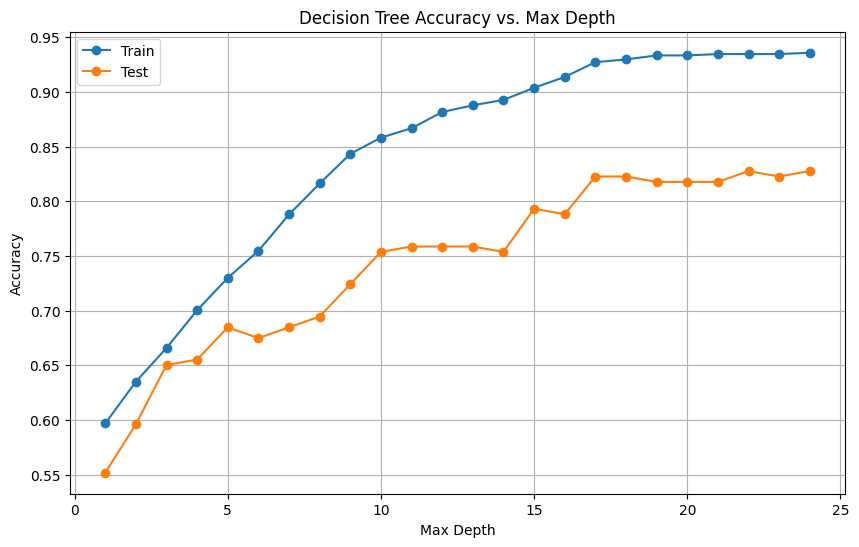

In [1133]:
# Varying max_depth

max_depth = range(1, 25)
trACC_DT = []
testACC_DT = []

for depth in max_depth:
  (
  train_pred_DT,
  test_pred_DT,
  train_accuracy_DT,
  test_accuracy_DT,
  train_precision_DT,
  test_precision_DT,
  train_recall_DT,
  test_recall_DT,
  train_f1_score_DT,
  test_f1_score_DT
  ) = predict_evaluate(DecisionTreeClassifier(max_depth=depth, random_state=42), X_train, X_test, y_train, y_test)
  trACC_DT.append(train_accuracy_DT)
  testACC_DT.append(test_accuracy_DT)

plt_plot_param={
    "tuning_param": max_depth,
    "training_acc": trACC_DT,
    "testing_acc": testACC_DT
    }
plt_title='Decision Tree Accuracy vs. Max Depth'
plt_xlabel='Max Depth'
plot_ylabel='Accuracy'

plot_train_test_accuracy(plt_plot_param, plt_title, plt_xlabel, plot_ylabel)


In [1134]:
tabulate_result({'DT after hyper parameter tuning': [
  train_accuracy_DT,
  test_accuracy_DT,
  train_precision_DT,
  test_precision_DT,
  train_recall_DT,
  test_recall_DT,
  train_f1_score_DT,
  test_f1_score_DT
]})

+---------------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+
| Algorithm                       |   Train Accuracy |   Test Accuracy |   Train Precision |   Test Precision |   Train Recall |   Test Recall |   Train F1-Score |   Test F1-Score |
+=================================+==================+=================+===================+==================+================+===============+==================+=================+
| DT after hyper parameter tuning |         0.935882 |        0.827586 |          0.935789 |         0.830843 |       0.935882 |      0.827586 |         0.935722 |        0.828108 |
+---------------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+


In [1135]:
# Best max_depth based on test accuracy
bestDepth_DT = max_depth[testACC_DT.index(max(testACC_DT))]
bestMax_DT = max(testACC_DT)
bestDepth_DT, bestMax_DT

(22, 0.8275862068965517)

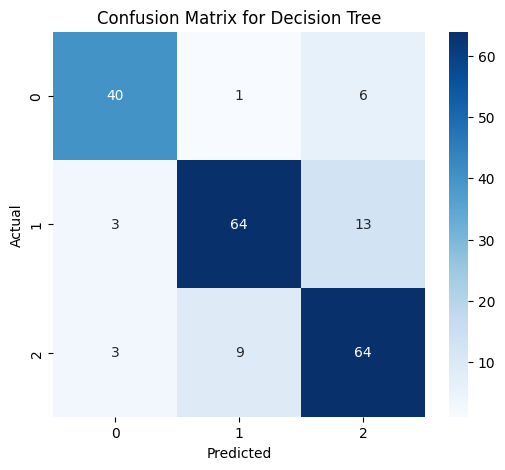

In [1136]:
plot_confusion_matrix(y_test, test_pred_DT, "Decision Tree")

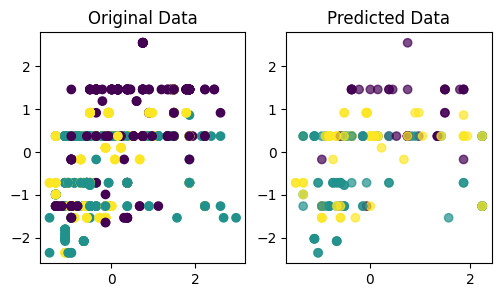

In [1137]:
plot_output(X_scaled, X_test, test_pred_DT)

# Hyperparameter tuning for Random Forest

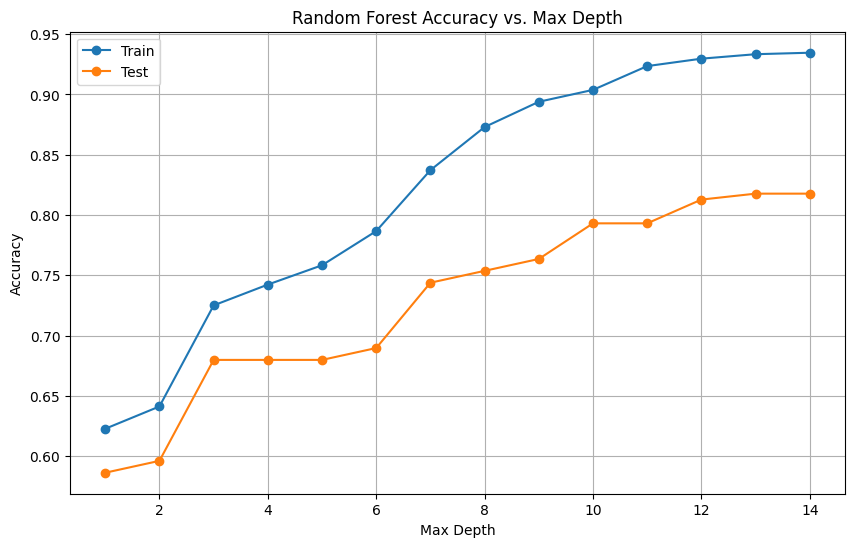

In [1138]:
# Varying max_depth

max_depth = range(1, 15)
trACC_RF = []
testACC_RF = []

for depth in max_depth:
  (
  train_pred_RF,
  test_pred_RF,
  train_accuracy_RF,
  test_accuracy_RF,
  train_precision_RF,
  test_precision_RF,
  train_recall_RF,
  test_recall_RF,
  train_f1_score_RF,
  test_f1_score_RF
  ) = predict_evaluate(RandomForestClassifier(max_depth=depth, random_state=42), X_train, X_test, y_train, y_test)
  trACC_RF.append(train_accuracy_RF)
  testACC_RF.append(test_accuracy_RF)

plt_plot_param={
    "tuning_param": max_depth,
    "training_acc": trACC_RF,
    "testing_acc": testACC_RF
    }
plt_title='Random Forest Accuracy vs. Max Depth'
plt_xlabel='Max Depth'
plot_ylabel='Accuracy'

plot_train_test_accuracy(plt_plot_param, plt_title, plt_xlabel, plot_ylabel)


In [1139]:
tabulate_result({'RF after hyper parameter tuning': [
  train_accuracy_RF,
  test_accuracy_RF,
  train_precision_RF,
  test_precision_RF,
  train_recall_RF,
  test_recall_RF,
  train_f1_score_RF,
  test_f1_score_RF
]})

+---------------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+
| Algorithm                       |   Train Accuracy |   Test Accuracy |   Train Precision |   Test Precision |   Train Recall |   Test Recall |   Train F1-Score |   Test F1-Score |
+=================================+==================+=================+===================+==================+================+===============+==================+=================+
| RF after hyper parameter tuning |         0.934649 |        0.817734 |          0.934586 |         0.822571 |       0.934649 |      0.817734 |         0.934499 |        0.818304 |
+---------------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+


In [1140]:
# Best max_depth based on test accuracy
bestDepth_RF = max_depth[testACC_RF.index(max(testACC_RF))]
bestMax_RF= max(testACC_RF)
bestDepth_RF, bestMax_RF

(13, 0.8177339901477833)

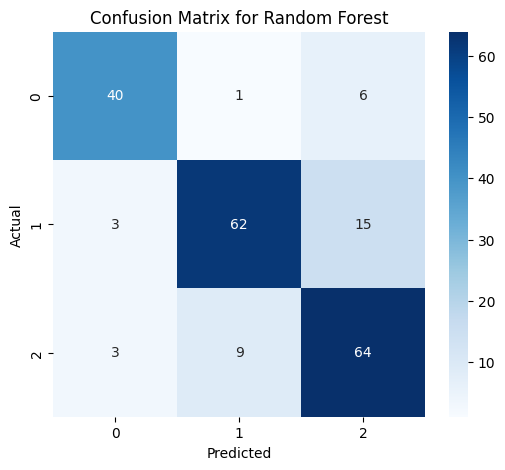

In [1141]:
plot_confusion_matrix(y_test, test_pred_RF, "Random Forest")

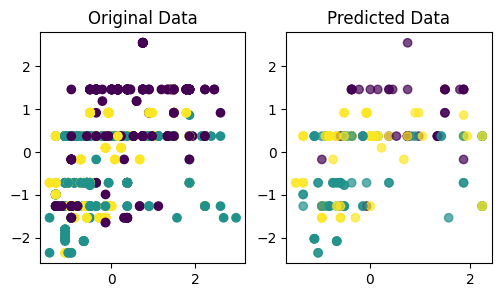

In [1142]:
plot_output(X_scaled, X_test, test_pred_RF)

# Hyperparameter tuning for KNN

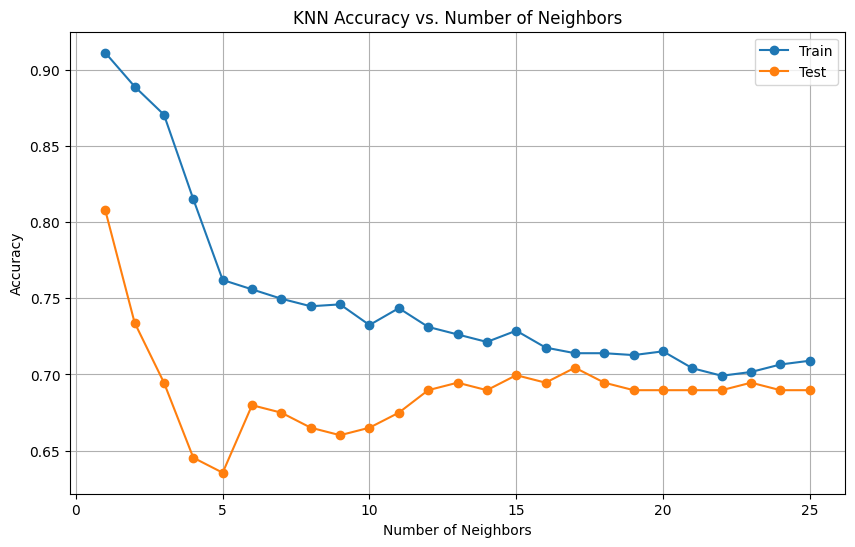

In [1143]:
# Varying n_neighbors
neighbors = range(1, 26)
trACC_KNN = []
testACC_KNN = []

for n_neighbors in neighbors:
  (
  train_pred_KNN,
  test_pred_KNN,
  train_accuracy_KNN,
  test_accuracy_KNN,
  train_precision_KNN,
  test_precision_KNN,
  train_recall_KNN,
  test_recall_KNN,
  train_f1_score_KNN,
  test_f1_score_KNN
  ) = predict_evaluate(KNeighborsClassifier(n_neighbors=n_neighbors), X_train, X_test, y_train, y_test)
  trACC_KNN.append(train_accuracy_KNN)
  testACC_KNN.append(test_accuracy_KNN)

plt_plot_param={
    "tuning_param": neighbors,
    "training_acc": trACC_KNN,
    "testing_acc": testACC_KNN
    }
plt_title='KNN Accuracy vs. Number of Neighbors'
plt_xlabel='Number of Neighbors'
plot_ylabel='Accuracy'

plot_train_test_accuracy(plt_plot_param, plt_title, plt_xlabel, plot_ylabel)


In [1144]:
tabulate_result({'KNN After hyper parameter tuning': [
  train_accuracy_KNN,
  test_accuracy_KNN,
  train_precision_KNN,
  test_precision_KNN,
  train_recall_KNN,
  test_recall_KNN,
  train_f1_score_KNN,
  test_f1_score_KNN
]})

+----------------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+
| Algorithm                        |   Train Accuracy |   Test Accuracy |   Train Precision |   Test Precision |   Train Recall |   Test Recall |   Train F1-Score |   Test F1-Score |
+==================================+==================+=================+===================+==================+================+===============+==================+=================+
| KNN After hyper parameter tuning |         0.709001 |        0.689655 |          0.705116 |         0.695997 |       0.709001 |      0.689655 |         0.703878 |        0.679918 |
+----------------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+


In [1145]:
# Best n_neighbors based on test accuracy
best_n_neighbors_KNN = neighbors[testACC_KNN.index(max(testACC_KNN))]
bestMax_KNN= max(testACC_KNN)
best_n_neighbors_KNN, bestMax_KNN

(1, 0.8078817733990148)

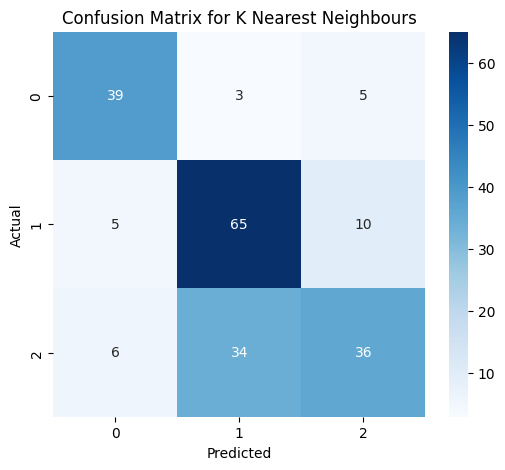

In [1146]:
plot_confusion_matrix(y_test, test_pred_KNN, "K Nearest Neighbours")

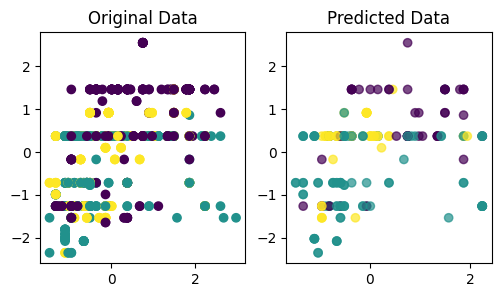

In [1147]:
plot_output(X_scaled, X_test, test_pred_KNN)

# Hyperparameter tuning for SVM

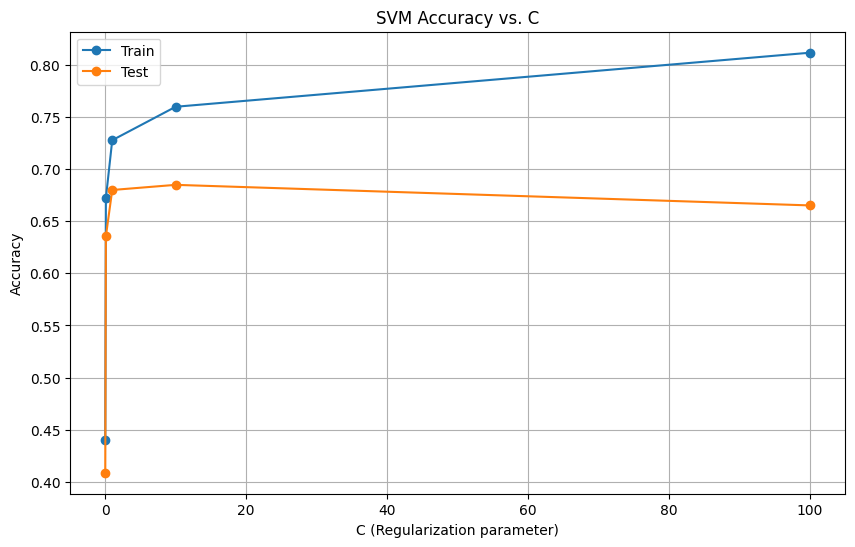

In [1148]:
# Varying C (Regularisation) parameter

C_range = np.logspace(-2, 2, 5)
trACC_SVM = []
testACC_SVM = []


for C in C_range:
  (train_pred_SVM,
  test_pred_SVM,
  train_accuracy_SVM,
  test_accuracy_SVM,
  train_precision_SVM,
  test_precision_SVM,
  train_recall_SVM,
  test_recall_SVM,
  train_f1_score_SVM,
  test_f1_score_SVM
  ) = predict_evaluate(SVC(kernel='rbf', C=C), X_train, X_test, y_train, y_test)
  trACC_SVM.append(train_accuracy_SVM)
  testACC_SVM.append(test_accuracy_SVM)



plt_plot_param={
    "tuning_param": C_range,
    "training_acc": trACC_SVM,
    "testing_acc": testACC_SVM
    }
plt_title='SVM Accuracy vs. C'
plt_xlabel='C (Regularization parameter)'
plt_ylabel='Accuracy'
plt_xscale='log'

plot_train_test_accuracy(plt_plot_param, plt_title, plt_xlabel, plt_ylabel, plt_xscale)


In [1149]:
tabulate_result({'SVM After hyper parameter tuning': [
  train_accuracy_SVM,
  test_accuracy_SVM,
  train_precision_SVM,
  test_precision_SVM,
  train_recall_SVM,
  test_recall_SVM,
  train_f1_score_SVM,
  test_f1_score_SVM
]})

+----------------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+
| Algorithm                        |   Train Accuracy |   Test Accuracy |   Train Precision |   Test Precision |   Train Recall |   Test Recall |   Train F1-Score |   Test F1-Score |
+==================================+==================+=================+===================+==================+================+===============+==================+=================+
| SVM After hyper parameter tuning |         0.811344 |        0.665025 |          0.815475 |         0.663955 |       0.811344 |      0.665025 |         0.804697 |        0.659286 |
+----------------------------------+------------------+-----------------+-------------------+------------------+----------------+---------------+------------------+-----------------+


In [1150]:
# Best C based on test accuracy
best_c_SVM = C_range[testACC_SVM.index(max(testACC_SVM))]
bestMax_SVM = max(testACC_SVM)
best_c_SVM, bestMax_SVM

(10.0, 0.6847290640394089)

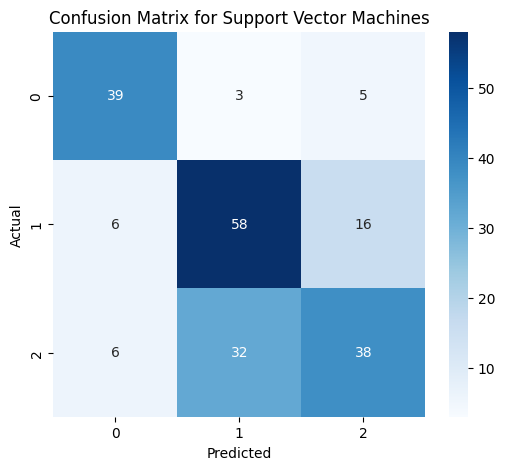

In [1151]:
plot_confusion_matrix(y_test, test_pred_SVM, "Support Vector Machines")

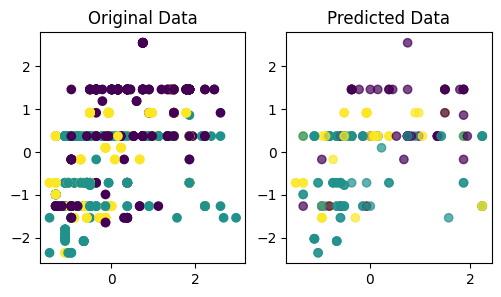

In [1152]:
plot_output(X_scaled, X_test, test_pred_SVM)

# Summary Table of Baseline Accuracy vs. Accuracy after Tuning

In [1153]:
tuned_algorithms = {
    "Decision Tree": [baseline_algorithms['Decision Tree'][0], train_accuracy_DT, baseline_algorithms['Decision Tree'][1], test_accuracy_DT, bestMax_DT, f"max_depth = {bestDepth_DT}"],
    "Random Forest": [baseline_algorithms['Random Forest'][0], train_accuracy_RF, baseline_algorithms['Random Forest'][1], test_accuracy_RF, bestMax_RF, f"max_depth = {bestDepth_RF}"],
    "K-Nearest Neighbors": [baseline_algorithms['K-Nearest Neighbors'][0], train_accuracy_KNN, baseline_algorithms['K-Nearest Neighbors'][1], test_accuracy_KNN, bestMax_KNN, f"n_neighbours = {best_n_neighbors_KNN}"],
    "Support Vector Machines": [baseline_algorithms['Support Vector Machines'][0], train_accuracy_SVM, baseline_algorithms['Support Vector Machines'][1], test_accuracy_SVM, bestMax_SVM, f"regularization param, c = {best_c_SVM}"]
}

tabulate_results(tuned_algorithms)

+-------------------------+-----------------------------+--------------------------+----------------------------+-------------------------+-----------------------------+--------------------------------+
| Algorithm               |   Train Accuracy (Baseline) |   Train Accuracy (Tuned) |   Test Accuracy (Baseline) |   Test Accuracy (Tuned) |   Max Test Accuracy (Tuned) | Max Test Accuracy At           |
+=========================+=============================+==========================+============================+=========================+=============================+================================+
| Decision Tree           |                    0.935882 |                 0.935882 |                   0.817734 |                0.827586 |                    0.827586 | max_depth = 22                 |
+-------------------------+-----------------------------+--------------------------+----------------------------+-------------------------+-----------------------------+-------------------